In [36]:
# importing all the libraries needed

import yfinance as yf
import pandas as pd
import os
from datetime import datetime

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.utils.class_weight import compute_class_weight

import ta

import numpy as np
import lightgbm as lgb

import matplotlib.pyplot as mlt

In [2]:
# Loading the Dataset
df = pd.read_csv('../data/masterdata/masterdata.csv')
df

,Date,Close,High,Low,Open,Volume,Ticker
0,2019-01-01,155.245453,160.280447,153.468395,158.848918,4726656,ADANIENT.NS
1,2019-01-02,152.876053,155.837810,150.556003,154.998640,2735262,ADANIENT.NS
2,2019-01-03,150.556000,154.110115,148.384047,152.925400,2758876,ADANIENT.NS
3,2019-01-04,150.605362,152.036875,148.087865,150.161101,2777308,ADANIENT.NS
4,2019-01-07,149.321945,152.481150,148.334693,150.950906,2714218,ADANIENT.NS
...,...,...,...,...,...,...,...
168731,2025-06-17,137.210007,143.300003,136.259995,140.899994,49586411,ZEEL.NS
168732,2025-06-18,133.789993,138.309998,132.970001,137.889999,10524157,ZEEL.NS
168733,2025-06-19,127.589996,134.839996,126.099998,133.100006,15756740,ZEEL.NS
168734,2025-06-20,133.080002,134.880005,127.300003,127.349998,14756339,ZEEL.NS


In [3]:
# Calculating momentum factors and label

# Calculate momentum factors
df['ret_1m'] = df.groupby('Ticker')['Close'].pct_change(21)
df['ret_3m'] = df.groupby('Ticker')['Close'].pct_change(63)
df['ret_6m'] = df.groupby('Ticker')['Close'].pct_change(126)
df['ret_12m'] = df.groupby('Ticker')['Close'].pct_change(252)

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# Adding technical indicators to the data
def add_technical_indicators(group):
    group = group.copy()
    group['mom_10'] = ta.momentum.ROCIndicator(close=group['Close'], window=10).roc()
    group['rsi_14'] = ta.momentum.RSIIndicator(close=group['Close'], window=14).rsi()
    group['macd'] = ta.trend.MACD(close=group['Close']).macd()
    group['sma_20'] = ta.trend.SMAIndicator(close=group['Close'], window=20).sma_indicator()
    group['ema_20'] = ta.trend.EMAIndicator(close=group['Close'], window=20).ema_indicator()
    group['atr_14'] = ta.volatility.AverageTrueRange(high=group['High'], low=group['Low'], close=group['Close'], window=14).average_true_range()
    group['obv'] = ta.volume.OnBalanceVolumeIndicator(close=group['Close'], volume=group['Volume']).on_balance_volume()
    return group


# Apply per ticker
df = df.groupby('Ticker').apply(add_technical_indicators).reset_index(drop=True)

In [6]:
df

,Date,Close,High,Low,Open,Volume,Ticker,ret_1m,ret_3m,ret_6m,ret_12m,mom_10,rsi_14,macd,sma_20,ema_20,atr_14,obv
0,2019-01-01,155.245453,160.280447,153.468395,158.848918,4726656,ADANIENT.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,4726656
1,2019-01-02,152.876053,155.837810,150.556003,154.998640,2735262,ADANIENT.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1991394
2,2019-01-03,150.556000,154.110115,148.384047,152.925400,2758876,ADANIENT.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-767482
3,2019-01-04,150.605362,152.036875,148.087865,150.161101,2777308,ADANIENT.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,2009826
4,2019-01-07,149.321945,152.481150,148.334693,150.950906,2714218,ADANIENT.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-704392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168731,2025-06-17,137.210007,143.300003,136.259995,140.899994,49586411,ZEEL.NS,0.067533,0.311132,0.018861,-0.162880,5.069309,69.416875,4.640531,129.972000,129.870920,4.659770,2246841606
168732,2025-06-18,133.789993,138.309998,132.970001,137.889999,10524157,ZEEL.NS,0.088520,0.335763,0.007986,-0.191429,4.547935,60.937626,4.391059,130.459000,130.244165,4.708358,2236317449
168733,2025-06-19,127.589996,134.839996,126.099998,133.100006,15756740,ZEEL.NS,0.028537,0.286319,-0.059695,-0.220723,-0.117427,49.203807,3.650976,130.473999,129.991387,4.996332,2220560709
168734,2025-06-20,133.080002,134.880005,127.300003,127.349998,14756339,ZEEL.NS,0.045487,0.341667,-0.020102,-0.181888,5.126792,57.084034,3.467482,130.722999,130.285541,5.180880,2235317048


In [7]:
df.to_csv("../data/masterdata/masterdata_with_indicators.csv", index=False)

In [8]:
# Adding Labels to the dataset

# Adding forward label
df['fwd_return'] = df.groupby('Ticker')['Close'].shift(-21) / df['Close'] - 1

# Creating month column to get month
df['Month'] = df['Date'].dt.to_period('M')

In [9]:
# Adding target label column to dataset

def label_by_quantile(group):
    group = group.copy()
    if group['fwd_return'].isnull().all():
        group['Label'] = None
        return group
    
    q_low = group['fwd_return'].quantile(0.3)
    q_high = group['fwd_return'].quantile(0.7)

    group['Label'] = 0
    group.loc[group['fwd_return'] <= q_low, 'Label'] = -1
    group.loc[group['fwd_return'] >= q_high, 'Label'] = 1
    
    return group

df = df.groupby('Month').apply(label_by_quantile).reset_index(drop=True)

# Drop NA labels (usually last few rows due to shifting)
df = df.dropna(subset=['Label'])

# Omitting all the 0 labels
df = df[df['Label'] != 0]

# Convert label to int
df['Label'] = df['Label'].astype(int)

In [10]:
df.to_csv('../data/masterdata/masterdata_with_labels.csv', index=False)

In [11]:
# Selecting features to include with the model

# Columns to remove for training
features = [
    'mom_10', 'rsi_14', 'macd',
    'sma_20', 'ema_20',
    'atr_14', 'obv',
    'ret_1m', 'ret_3m', 'ret_6m', 'ret_12m',
    'Volume'
]
target = 'Label'

df_model = df.dropna(subset=features + [target])

train_df = df_model[df_model['Date'] <= pd.to_datetime('2022-12-21')]
test_df = df_model[df_model['Date'] > pd.to_datetime('2022-12-21')]

In [12]:
# Feature scaling of the training data

# Initializing scaler and applying to data
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features])
X_test = scaler.transform(test_df[features])

y_train = train_df[target]
y_test = test_df[target]

In [13]:
# Training the model

# Initializing the LightGBM model
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
)

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 45662, number of used features: 12
[LightGBM] [Info] Start training from score -0.687382
[LightGBM] [Info] Start training from score -0.698946
[LightGBM] [Info] Start training from score -34.538776


LGBMClassifier(num_class=3, objective='multiclass', random_state=42)

In [14]:
# Making the predictions
y_pred = model.predict(X_test)

In [15]:
# Evaluation to check the score
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

          -1       0.52      0.59      0.56     18890
           1       0.54      0.47      0.50     19133

    accuracy                           0.53     38023
   macro avg       0.53      0.53      0.53     38023
weighted avg       0.53      0.53      0.53     38023

Confusion Matrix:
[[11196  7694]
 [10139  8994]]


In [16]:
# Using Randomized Search CV to improve score

param_grid = {
    'num_leaves': [127, 255],
    'max_depth': [-1],
    'learning_rate': [0.01],
    'n_estimators': [300],
    'subsample': [1.0],
    'colsample_bytree': [0.8]
}

model = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=30,  # Try 30 combinations
    scoring='f1_weighted',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=30. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 15222, number of used features: 12
[LightGBM] [Info] Start training from score -0.671185
[LightGBM] [Info] Start training from score -0.715602
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 22832, number of used features: 12
[LightGBM] [Info] Start training from score -0.672256
[LightGBM] [Info] Start training from score -0.714484
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Auto-choosing 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMClassifier(num_class=3, objective='multiclass',
                                            random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8],
                                        'learning_rate': [0.01],
                                        'max_depth': [-1],
                                        'n_estimators': [300],
                                        'num_leaves': [127, 255],
                                        'subsample': [1.0]},
                   random_state=42, scoring='f1_weighted', verbose=1)

In [17]:
# Printing randomized search training results


print("Best params:", random_search.best_params_)
print("Best score (cv f1_weighted):", random_search.best_score_)

Best params: {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best score (cv f1_weighted): 0.5455135230677219


In [18]:
# Retraining with the best params

# Redefining best params
best_params = random_search.best_params_

# Fit the model
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

y_pred = final_model.predict(X_test)

print("Final Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Info] Number of positive: 22699, number of negative: 22963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 45662, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497109 -> initscore=-0.011563
[LightGBM] [Info] Start training from score -0.011563
Final Classification Report:
              precision    recall  f1-score   support

          -1       0.52      0.58      0.55     18890
           1       0.53      0.47      0.50     19133

    accuracy                           0.52     38023
   macro avg       0.53      0.52      0.52     38023
weighted avg       0.53      0.52      0.52     38023

Confusion Matrix:
[[11000  7890]
 [10186  8947]]


In [23]:
# Predicting probabilities on the test set

probs = final_model.predict_proba(X_test)

# Confidence for buy class
test_df['pred_label'] = final_model.predict(X_test)
test_df['buy_confidence'] = probs[:, 1]  # probability of being Label = 1

/var/folders/gs/9fnmdkk57pz7qrd9_vcy4l500000gn/T/ipykernel_99092/1273094257.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_label'] = final_model.predict(X_test)
/var/folders/gs/9fnmdkk57pz7qrd9_vcy4l500000gn/T/ipykernel_99092/1273094257.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['buy_confidence'] = probs[:, 1]  # probability of being Label = 1


In [30]:
# Getting the top 10 buys for the month

top_n = 10
test_df['Month'] = pd.to_datetime(test_df['Date']).dt.to_period('M')

# Get top N stocks per month based on buy confidence
last_signals = (
    test_df[test_df['pred_label'] == 1]
    .sort_values(['Ticker', 'Month', 'Date'])
    .groupby(['Ticker', 'Month'])
    .tail(1)  # OR .head(1) for first day
    .reset_index(drop=True)
)

monthly_top_buys = (
    last_signals
    .sort_values(['Month', 'buy_confidence'], ascending=[True, False])
    .groupby('Month')
    .head(top_n)
    .reset_index(drop=True)
)

monthly_top_buys[['Month', 'Date', 'Ticker', 'buy_confidence', 'fwd_return']].head(10)

/var/folders/gs/9fnmdkk57pz7qrd9_vcy4l500000gn/T/ipykernel_99092/1876922326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Month'] = pd.to_datetime(test_df['Date']).dt.to_period('M')


,Month,Date,Ticker,buy_confidence,fwd_return
0,2022-12,2022-12-29,PNB.NS,0.755003,-0.084838
1,2022-12,2022-12-30,LTTS.NS,0.752822,-0.094379
2,2022-12,2022-12-30,ADANIENT.NS,0.748409,-0.229230
3,2022-12,2022-12-30,METROPOLIS.NS,0.705564,0.013183
4,2022-12,2022-12-26,TORNTPHARM.NS,0.686790,0.009556
5,2022-12,2022-12-30,BANKBARODA.NS,0.674658,-0.096123
6,2022-12,2022-12-29,COALINDIA.NS,0.671213,0.018949
7,2022-12,2022-12-28,ONGC.NS,0.662375,0.026060
8,2022-12,2022-12-30,UBL.NS,0.662110,-0.063331
9,2022-12,2022-12-30,ASIANPAINT.NS,0.659882,-0.117248


In [31]:
# Overall market average (baseline)
market_returns = test_df.groupby('Month')['fwd_return'].mean().reset_index()
market_returns.rename(columns={'fwd_return': 'market_avg_return'}, inplace=True)

# Join with your model portfolio
portfolio_returns = monthly_top_buys.groupby('Month')['fwd_return'].mean().reset_index()
portfolio_returns.rename(columns={'fwd_return': 'model_return'}, inplace=True)

comparison = pd.merge(portfolio_returns, market_returns, on='Month')
comparison['alpha'] = comparison['model_return'] - comparison['market_avg_return']

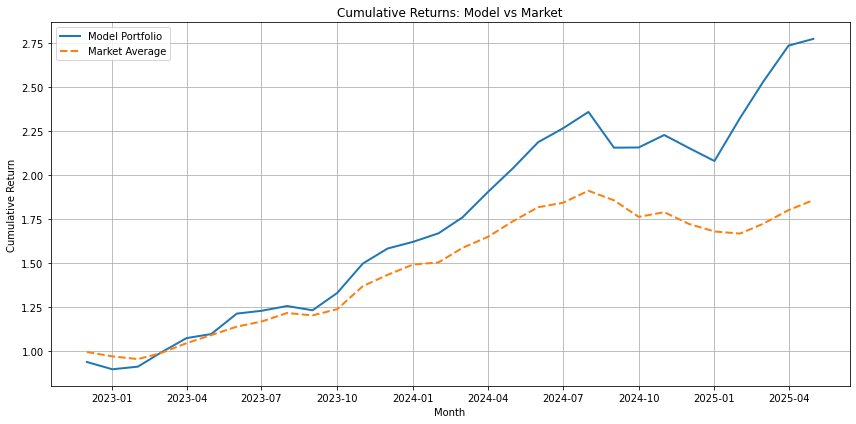

In [32]:
import matplotlib.pyplot as plt

# Convert Month to datetime for plotting
comparison['Month'] = pd.to_datetime(comparison['Month'].astype(str))

# Cumulative returns
comparison['model_cum'] = (1 + comparison['model_return']).cumprod()
comparison['market_cum'] = (1 + comparison['market_avg_return']).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(comparison['Month'], comparison['model_cum'], label='Model Portfolio', linewidth=2)
plt.plot(comparison['Month'], comparison['market_cum'], label='Market Average', linewidth=2, linestyle='--')
plt.title("Cumulative Returns: Model vs Market")
plt.xlabel("Month")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

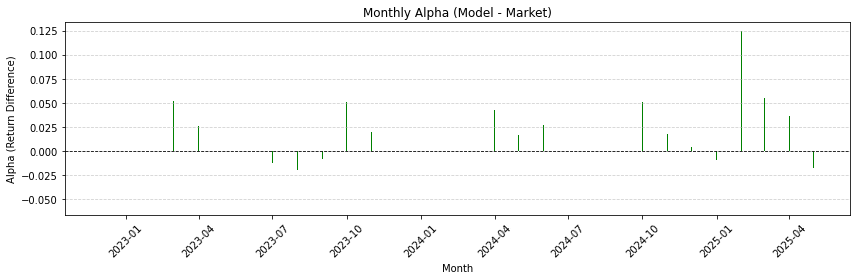

In [33]:
plt.figure(figsize=(12, 4))
plt.bar(comparison['Month'], comparison['alpha'], color='green')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Monthly Alpha (Model - Market)")
plt.xlabel("Month")
plt.ylabel("Alpha (Return Difference)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [34]:
comparison

,Month,model_return,market_avg_return,alpha,model_cum,market_cum
0,2022-12-01,-0.061740,-0.004842,-0.056898,0.938260,0.995158
1,2023-01-01,-0.044071,-0.025162,-0.018909,0.896910,0.970117
2,2023-02-01,0.016821,-0.015855,0.032676,0.911997,0.954735
3,2023-03-01,0.087731,0.036230,0.051501,0.992007,0.989325
4,2023-04-01,0.082659,0.056585,0.026074,1.074005,1.045306
5,2023-05-01,0.021478,0.043759,-0.022281,1.097072,1.091048
6,2023-06-01,0.105828,0.044017,0.061810,1.213172,1.139073
7,2023-07-01,0.013134,0.025442,-0.012308,1.229106,1.168053
8,2023-08-01,0.022062,0.041478,-0.019416,1.256223,1.216501
9,2023-09-01,-0.019253,-0.011030,-0.008222,1.232037,1.203082


In [ ]:
# Adding additional metrics and backtesting

# Applying transaction cost for real world scenario
transaction_cost = 0.004
comparison['net_model_return'] = comparison['model_return'] - transaction_cost

# Recompute cumulative return
comparison['net_model_cum'] = (1 + comparison['net_model_return']).cumprod()

# Computing Sharpe ratio
mean_ret = comparison['net_model_return'].mean()
std_ret = comparison['net_model_return'].std()
sharpe_ratio = (mean_ret / std_ret) * np.sqrt(12)  # annualized

# Calculating Max Drawdown
cum_returns = comparison['net_model_cum']
rolling_max = cum_returns.cummax()
drawdown = cum_returns / rolling_max - 1
max_drawdown = drawdown.min()

# Calculating Win Rate
win_rate = (comparison['net_model_return'] > 0).mean()

# Printing The Result
print("💡 Backtest Stats")
print(f"Sharpe Ratio:       {sharpe_ratio:.2f}")
print(f"Max Drawdown:       {max_drawdown:.2%}")
print(f"Monthly Win Rate:   {win_rate:.2%}")

💡 Backtest Stats
Sharpe Ratio:       2.06
Max Drawdown:       -13.61%
Monthly Win Rate:   76.67%


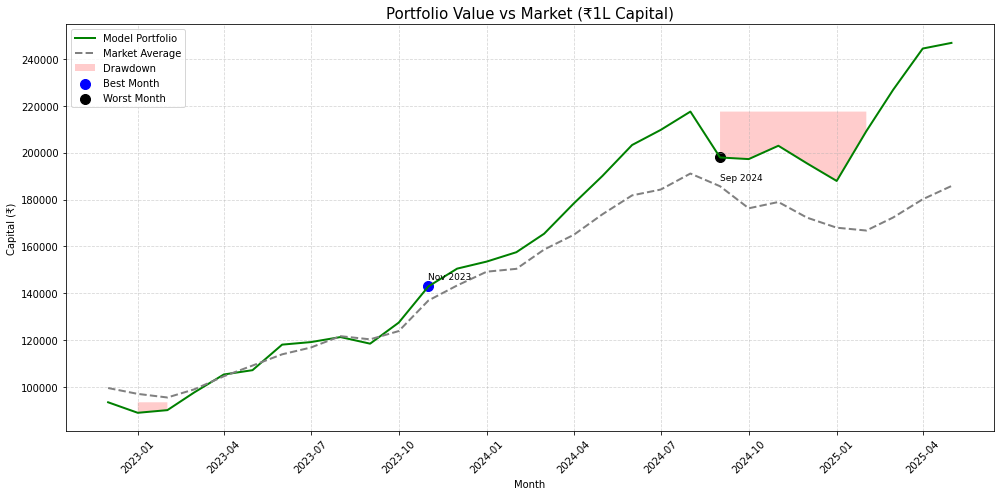

In [39]:
# Tracking Capital

# Base capital
starting_capital = 100000
comparison['model_capital'] = starting_capital * comparison['net_model_cum']
comparison['market_capital'] = starting_capital * comparison['market_cum']

# Drawdown (for model)
rolling_max = comparison['model_capital'].cummax()
drawdown = comparison['model_capital'] / rolling_max - 1

# Best and worst month
best_month = comparison.loc[comparison['net_model_return'].idxmax()]
worst_month = comparison.loc[comparison['net_model_return'].idxmin()]

# Plot
plt.figure(figsize=(14, 7))

# Capital lines
plt.plot(comparison['Month'], comparison['model_capital'], label='Model Portfolio', linewidth=2, color='green')
plt.plot(comparison['Month'], comparison['market_capital'], label='Market Average', linestyle='--', linewidth=2, color='gray')

# Drawdown shaded area
plt.fill_between(comparison['Month'], comparison['model_capital'], rolling_max, where=drawdown < 0,
                 facecolor='red', alpha=0.2, label='Drawdown')

# Annotations
plt.scatter(best_month['Month'], best_month['model_capital'], color='blue', s=100, label='Best Month')
plt.text(best_month['Month'], best_month['model_capital'] * 1.02, f"{best_month['Month'].strftime('%b %Y')}", fontsize=9)

plt.scatter(worst_month['Month'], worst_month['model_capital'], color='black', s=100, label='Worst Month')
plt.text(worst_month['Month'], worst_month['model_capital'] * 0.95, f"{worst_month['Month'].strftime('%b %Y')}", fontsize=9)

# Labels and grid
plt.title("Portfolio Value vs Market (₹1L Capital)", fontsize=15)
plt.xlabel("Month")
plt.ylabel("Capital (₹)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Backtesting

def backtest_portfolio(df, return_column='model_return', cost=0.004, capital=100000):
    df = df.copy()

    